# Chap 3 線形回帰

## 問題設定


$N$ 個の観測値 ${\bf x}_n$, $(n=1, ..., N)$ とそれに対応する目標値 ${\bf t_n}$ のデータから
${\bf x}$ と ${\bf t}$ の関係をモデル化する。

線形回帰では、$M$ 個の重み係数 $w_j$, $(j=1, ..., M)$ と基底関数 ${\phi_j({\bf x})}$ の線形和
$$
y({\bf x}, {\bf w}) = \sum_{j=1}^{M} w_j \phi_j({\bf x}) = {\bf w}^T {\bf \phi(x)}
$$
をモデルとし、 $w_j$ を推定する。


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 基底関数

1. そのまま
    $$\phi_j(x) = x$$
2. 多項式
    $$\phi_j(x) = x^j$$
3. ガウス
    $$\phi_j(x) = \exp\left(-\frac{(x-\mu_j)^2}{2s^2}\right)$$
4. ロジスティックシグモイド
    $$\phi_j(x) = \frac{1}{1 + \exp\left((x - \mu_j)/s\right)}$$

(図 3.1 (p137))

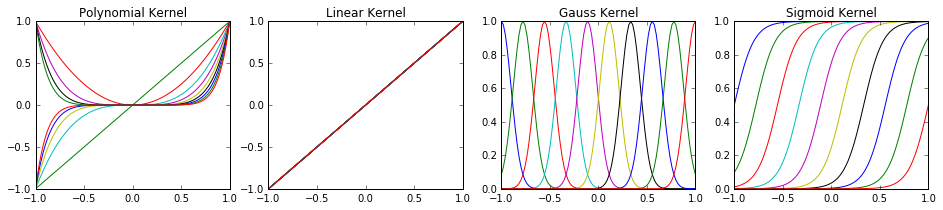

In [3]:
def basisNone(x, dmy1=None, dmy2=None, dmy3=None):
    return x

def basisPoly(x, j, dmy1=None, dmy2=None):
    return x ** j

def basisGauss(x, j, mu, s):
    return np.exp(- (x-mu[j]) ** 2 / (2 * s ** 2))

def basisSigmoid(x, j, mu, s):
    return 1.0 / (1 + np.exp(-(x - mu[j])/s))

basis = {
    "Linear": basisNone,
    "Polynomial": basisPoly,
    "Gauss": basisGauss,
    "Sigmoid": basisSigmoid,
}

x = np.linspace(-1, 1, 100)
mu = np.linspace(-1, 1, 10)

plt.figure(figsize=(16, 3))
for ikey, key in enumerate(basis):
    plt.subplot(1, 4, ikey + 1)
    plt.title(key + " Kernel")
    for j in range(len(mu)):
        plt.plot(x, [basis[key](tmpx, j, mu, 0.1) for tmpx in x])


In [4]:
def y(x, w, basisName, mu=None, s=None):
    ret = w[0]
    for index in range(1, len(w)):
        ret += w[index] * basis[basisName](x, index, mu, s)
    return ret

# 例題:  $\sin$ 関数を使った以下の関係式を、$M=10$ 次元で近似

観測は加法性ノイズ $\epsilon$ が含まれる
$$
y(x) = 2  \sin(x) + 3 + \epsilon \\
\epsilon \sim N(0, \beta^{-1})
$$
* $x \in [-5, 5]$
* $M$: 線形回帰の次元数
* $N$: サンプル数
* $\beta$: 加法性ノイズの精度

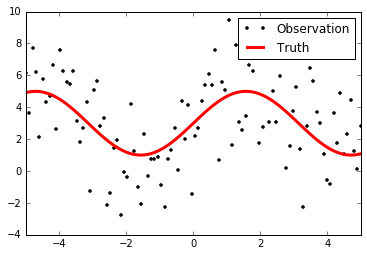

In [61]:
N = 100   # サンプル数
M = 5     # モデル次元
b  = 0.5   # ノイズの精度

x_opt = np.linspace(-5, 5, N)
y_opt = 2 * np.sin(x_opt) + 3
y_obs = (y_opt + np.random.normal(0, 1.0/b, len(x_opt)))[:, np.newaxis]

plt.plot(x_opt, y_obs, "k.", label="Observation")
plt.plot(x_opt, y_opt, "r-", linewidth=3, label="Truth")
plt.xlim(-5, 5)
plt.legend()

# ${\bf w}$ の最尤推定

重みの最尤推定は以下の式でもとまる
$$
{\bf w}_{ML} = (\Phi^T\Phi)^{-1} \Phi^T{\bf t}
$$
ただし、${\bf \Phi} \in R^{N \times M}$ は計画行列で、その $i$ 行 $j$ 列要素 は　$\phi_j(x_i)$

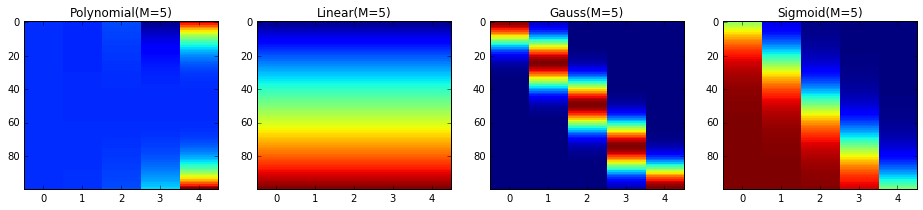

In [62]:
# 計画行列を求める
# s は全て 1 で固定。

def makeDesignMatrix(x, basis, mu, s):
    ret = np.zeros((len(x), len(mu)))
    for i in range(len(x)):
        for j in range(len(mu)):
            ret[i][ j] = basis(x[i], j, mu, s)
    return ret

mu = np.linspace(min(x_opt), max(x_opt), M)
s = 1

designMatrix = {} 
plt.figure(figsize=(16, 3))
for ikey, key in enumerate(basis):
    designMatrix[key] = makeDesignMatrix(x_opt, basis[key], mu, s)
    plt.subplot(1, 4, ikey+1)
    plt.title(key + "(M=%d)" % M)
    plt.imshow(designMatrix[key], aspect="auto", interpolation="nearest")

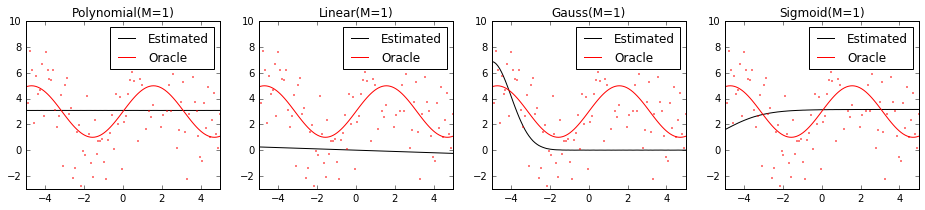

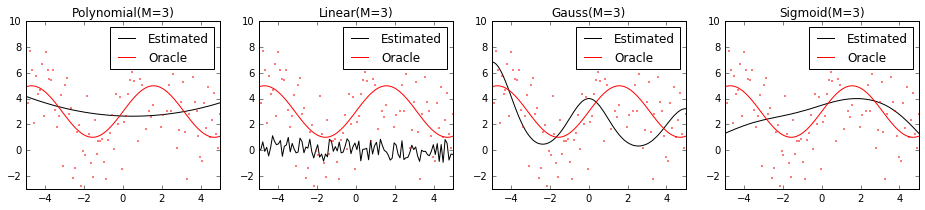

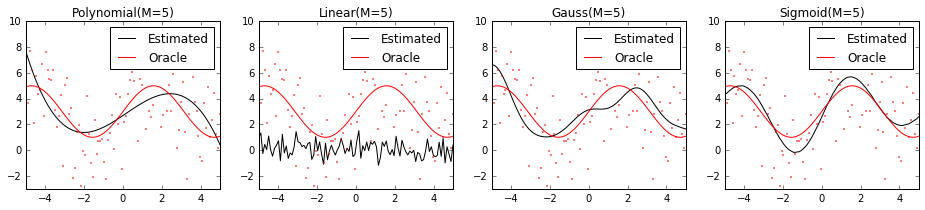

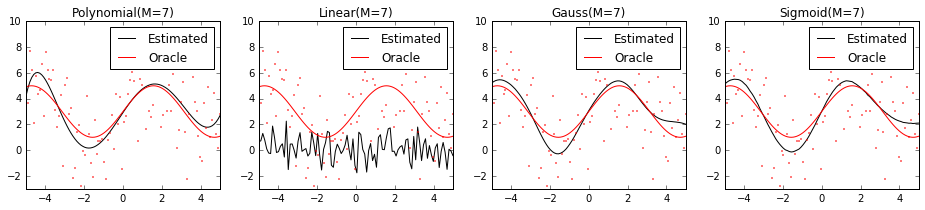

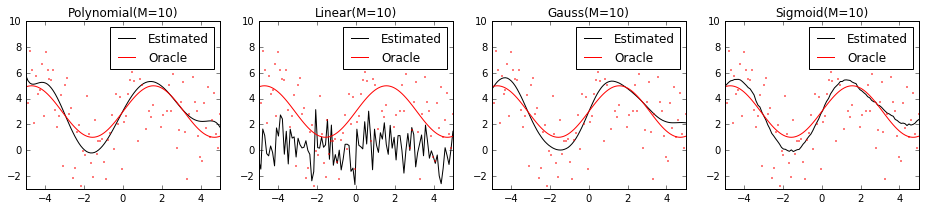

In [63]:
# 基底関数ごとに最尤推定を行い、結果をプロット
for M in [1, 3, 5, 7, 10]:
    mu = np.linspace(min(x_opt), max(x_opt), M)
    s = 1.0

    plt.figure(figsize=(16, 3))
    for ikey, key in enumerate(basis):
        phi = makeDesignMatrix(x_opt, basis[key], mu, s) + np.random.uniform(0, 0.001, (N, M))
        phit = phi.transpose()
        wml = np.dot(np.dot(np.linalg.inv(np.dot(phit, phi)), phit), y_obs)
        bml = 1.0 / (1.0 / N + sum([(y_obs[i] - np.dot(wml.transpose(), phi[i, :]))**2 for i in range(N)]))
    
        plt.subplot(1, 4, ikey+1)
        plt.title(key + "(M=%d)" % M)
        plt.plot(x_opt, [np.dot(wml.transpose(), phi[i, :]) for i in range(N)], "k", label="Estimated")
        plt.plot(x_opt, y_opt, "r", label="Oracle")
        plt.plot(x_opt, y_obs, "r.",  markersize=2)

        plt.ylim([-3, 10])
        plt.xlim([min(x_opt), max(x_opt)])
        plt.legend()

# 正則化項

誤差関数　$E_D({\bf w})$ に正則化項 $E_W({\bf w})$ と正則化係数 $\lambda$ を追加する
$$
\underset{\bf w}{\operatorname{argmin}} E_D({\bf w}) + \lambda E_W({\bf x})\\
E_D({\bf w}) = \frac{1}{2} \sum_{i=1}^{N} \left(t_i - {\bf w}^T\phi({\bf x}_i)\right)^2 \\
E_W({\bf w}) = \frac{1}{2} {\bf w}^T{\bf w}
$$

最尤推定は

$$
{\bf w}_{ML} = (\lambda{\bf I} + \Phi^T\Phi)^{-1} \Phi^T{\bf t}
$$

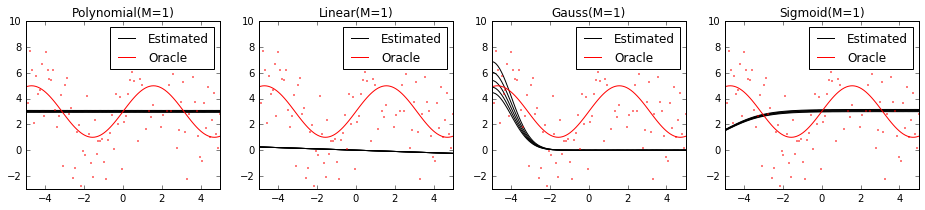

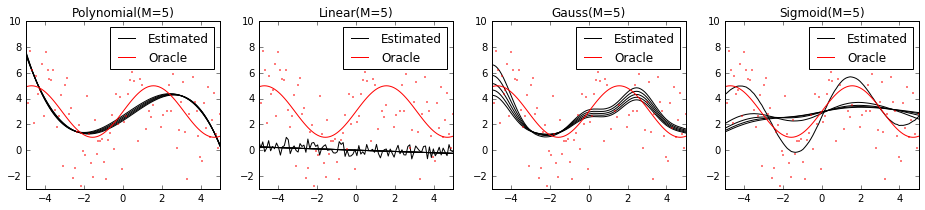

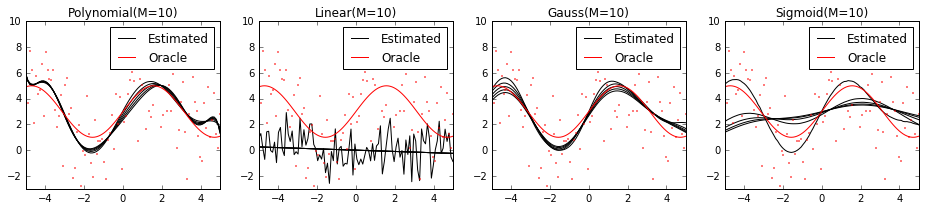

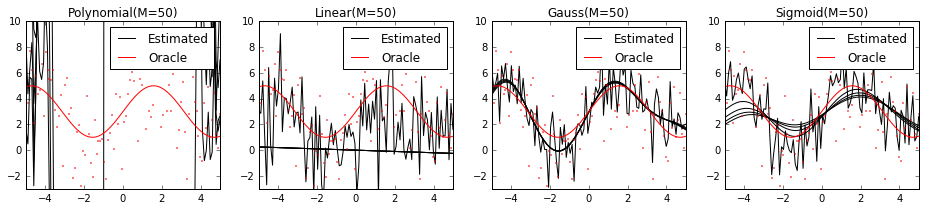

In [64]:
# 基底関数ごとに, M と　lambda を変えながら w の最尤推定を行い、結果をそれぞれプロット
for M in [1, 5, 10, 50]:
    mu = np.linspace(min(x_opt), max(x_opt), M)
    s = 1.0

    plt.figure(figsize=(16, 3))
    for ikey, key in enumerate(basis):
        phi = makeDesignMatrix(x_opt, basis[key], mu, s) + np.random.uniform(0, 0.001, (N, M))
        phit = phi.transpose()
        
        plt.subplot(1, 4, ikey+1)
        plt.title(key + "(M=%d)" % M) 
        for lmd in np.linspace(0, 5, 5):
            wml = np.dot(np.dot(np.linalg.inv(lmd * np.eye(M) + np.dot(phit, phi)), phit), y_obs)    
            plt.plot(x_opt, [np.dot(wml.transpose(), phi[i, :]) for i in range(N)], "k", label="Estimated" if lmd == 0 else "")

        
        plt.plot(x_opt, y_opt, "r", label="Oracle")
        plt.plot(x_opt, y_obs, "r.",  markersize=2)

        plt.ylim([-3, 10])
        plt.xlim([min(x_opt), max(x_opt)])
        plt.legend()

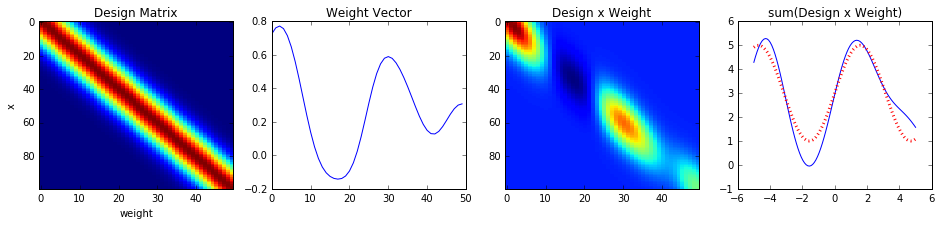

In [68]:
mu = np.linspace(min(x_opt), max(x_opt), M)
phi = makeDesignMatrix(x_opt, basis["Gauss"], mu, s)
phit = phi.transpose()
wml = np.dot(np.dot(np.linalg.inv(lmd * np.eye(M) + np.dot(phit, phi)), phit), y_obs)    

plt.figure(figsize=(16, 3))
plt.subplot(1, 4, 1)
plt.imshow(phi, aspect="auto", interpolation="nearest")
plt.title("Design Matrix")
plt.ylabel("x")
plt.xlabel("weight")

plt.subplot(1, 4, 2)
out = np.zeros((N, M))
plt.plot(wml)
plt.title("Weight Vector")
#plt.imshow(out,  aspect="auto", interpolation="nearest")

plt.subplot(1, 4, 3)
dw = (wml.transpose() * phi).transpose()
plt.imshow(dw.transpose(), aspect="auto", interpolation="nearest")
plt.title("Design x Weight")

plt.subplot(1, 4, 4)
plt.plot(x_opt, dw.sum(0))
plt.plot(x_opt, y_opt, "r:", linewidth=3)
plt.title("sum(Design x Weight)")